In [1]:
import os

import numpy as np
from scipy.sparse.linalg import eigsh

from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import LocalOperator, spin

import matplotlib.pyplot as plt

Selected two-point correlation pairs: [(0, 4), (4, 8)]


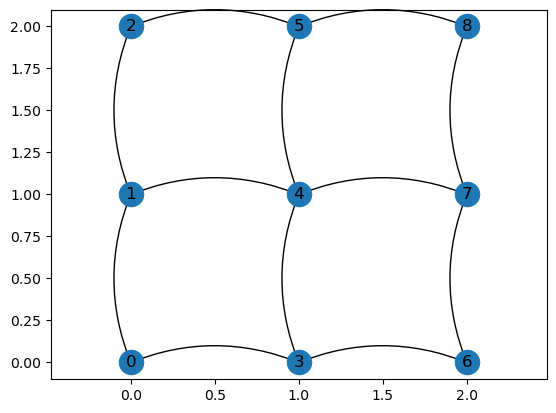

In [4]:
# we need to choose an even SIDE_LENGTH to have a bisector if we ever impose total_sz=0
SIDE_LENGTH = 3


def main_diagonal_pairs(graph):
    coords = np.asarray(graph.basis_coords, dtype=int)

    Lx = coords[:, 0].max() + 1
    Ly = coords[:, 1].max() + 1
    assert Lx == Ly == SIDE_LENGTH

    xy_to_id = {(c[0], c[1]): i for i, c in enumerate(coords)}

    pairs = [(xy_to_id[(x, x)], xy_to_id[((x + 1) % Lx, (x + 1) % Ly)]) for x in range(Lx)]
    return pairs[:-1]


def all_diagonal_pairs(graph):
    coords = np.asarray(graph.basis_coords, dtype=int)

    Lx = coords[:, 0].max() + 1
    Ly = coords[:, 1].max() + 1
    assert Lx == Ly == SIDE_LENGTH

    xy_to_id = {(c[0], c[1]): i for i, c in enumerate(coords)}

    pairs = [(xy_to_id[(x, y)], xy_to_id[((x + 1) % Lx, (y + 1) % Ly)]) for x in range(Lx) for y in range(Ly)]
    return pairs


#### DRAW GRAPH AND SELECT CORRELATION PAIRS ####

graph = Hypercube(length=SIDE_LENGTH, n_dim=2, pbc=False)
graph.draw()

corr_pairs = main_diagonal_pairs(graph)
#corr_pairs = list(graph.edges())
#corr_pairs = all_diagonal_pairs(graph)

print(f"Selected two-point correlation pairs: {corr_pairs}")

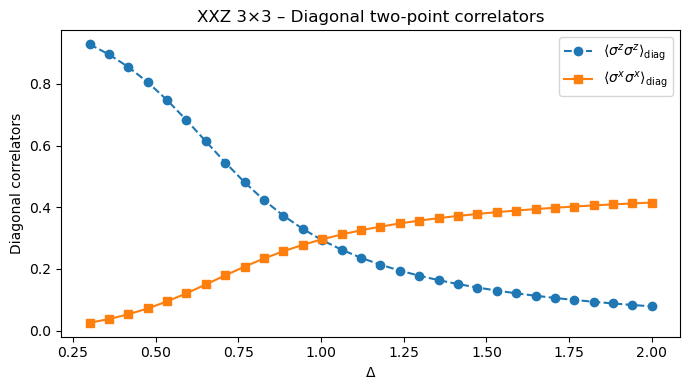

In [5]:
hilbert = Spin(s=0.5, N=graph.n_nodes)


def xxz_hamiltonian(hilbert: Spin, graph: Hypercube, delta: float, eps: float = 1e-3) -> LocalOperator:
    ham = LocalOperator(hilbert, dtype=np.complex128)

    for u, v in graph.edges():
        ham += delta * (
                spin.sigmax(hilbert, u) * spin.sigmax(hilbert, v)
                + spin.sigmay(hilbert, u) * spin.sigmay(hilbert, v)
        )
        ham += spin.sigmaz(hilbert, u) * spin.sigmaz(hilbert, v)

    # tiny field to lift degeneracy (optional)
    # for i in range(graph.n_nodes):
    #     ham -= eps * spin.sigmaz(hilbert, i)

    return ham


def ground_state(ham: LocalOperator):
    vals, vecs = eigsh(ham.to_sparse(), k=1, which="SA")
    return vals[0], vecs[:, 0]


def two_point_correlators(state: np.ndarray, pair_indices):
    psi = np.asarray(state, dtype=np.complex128)
    n = len(pair_indices)

    Czz = LocalOperator(hilbert, dtype=np.complex128)
    Cxx = LocalOperator(hilbert, dtype=np.complex128)

    for u, v in pair_indices:
        Czz += spin.sigmaz(hilbert, u) * spin.sigmaz(hilbert, v)
        Cxx += spin.sigmax(hilbert, u) * spin.sigmax(hilbert, v)

    Czz /= n
    Cxx /= n

    Czz_sp = Czz.to_sparse()
    Cxx_sp = Cxx.to_sparse()

    czz = np.vdot(psi, Czz_sp @ psi).real
    cxx = np.vdot(psi, Cxx_sp @ psi).real

    return czz, cxx


#### SWEEP OVER DELTA ####

delta_min = 0.3
delta_max = 2.0
num_points = 30
deltas = np.linspace(delta_min, delta_max, num_points)

czz_vals, cxx_vals = [], []
for delta in deltas:
    ham = xxz_hamiltonian(hilbert, graph, float(delta))
    _, psi = ground_state(ham)
    czz, cxx = two_point_correlators(psi, corr_pairs)
    czz_vals.append(czz)
    cxx_vals.append(cxx)

cxx_vals = np.array(cxx_vals)
czz_vals = np.array(czz_vals)


#### PLOTTING ####

plt.figure(figsize=(7, 4))
plt.plot(deltas, czz_vals, "o--", label=r"$\langle \sigma^z \sigma^z \rangle_{\rm diag}$")
plt.plot(deltas, cxx_vals, "s-",  label=r"$\langle \sigma^x \sigma^x \rangle_{\rm diag}$")

plt.xlabel(r"$\Delta$")
plt.ylabel("Diagonal correlators")
plt.title(f"XXZ {SIDE_LENGTH}×{SIDE_LENGTH} – Diagonal two-point correlators")
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
data = np.column_stack([deltas, czz_vals, cxx_vals])
header = "delta,czz_diag,cxx_diag"

file_name = f"xxz_{SIDE_LENGTH}x{SIDE_LENGTH}_correlations_ref.csv"

np.savetxt(file_name, data, delimiter=",", header=header, comments="")
print(f"Saved reference correlators to: {os.path.abspath(file_name)}")

Saved reference correlators to: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_merge/xxz_dynamics/xxz_4x4_correlations_ref.csv
